<a href="https://colab.research.google.com/github/UmrAsf/LungScanCNN/blob/main/CSEECNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = '/content/drive/My Drive/archive.zip'  # Replace with actual path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # Extracts contents to /content in Colab

In [ ]:
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.8463 - auc: 0.8653 - loss: 0.5066 - val_accuracy: 0.9160 - val_auc: 0.9874 - val_loss: 0.1882
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 0.9375 - auc: 0.9744 - loss: 0.1432

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 58s 444ms/step - accuracy: 0.9375 - auc: 0.9744 - loss: 0.1432 - val_accuracy: 0.9043 - val_auc: 0.9860 - val_loss: 0.2120
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9456 - auc: 0.9840 - loss: 0.1395 - val_accuracy: 0.9561 - val_auc: 0.9886 - val_loss: 0.1300
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 448ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0387 - val_accuracy: 0.9424 - val_auc: 0.9871 - val_loss: 0.1550
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9511 - auc: 0.9878 - loss: 0.1229 - val_accuracy: 0.9434 - val_auc: 0.9909 - val_loss: 0.1407
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 82s 630ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0472 - val_accuracy: 0.9326 - val_auc: 0.9910 - val_loss: 0.1626
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9529 - auc: 0.9916 - loss: 0.1047 - val_accuracy: 0.9482 - val_auc: 0.9916 - val_loss: 0.1235
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━

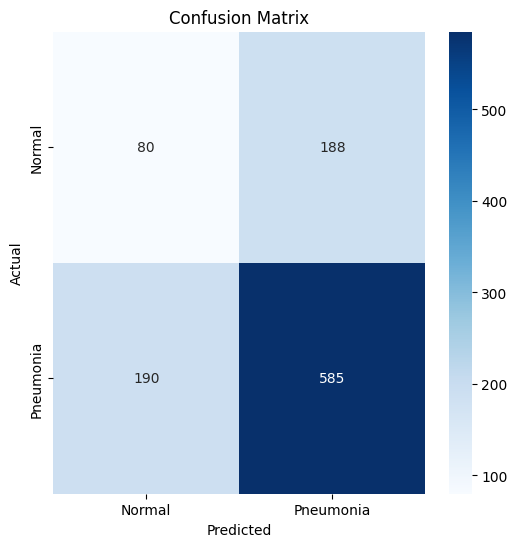

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the paths to the dataset directories
train_dir = '/content/chest_xray/train'  # Only using train_dir here

# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224  # MobileNetV2 input size
BATCH_SIZE = 32

# Set up data generator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=[1.2, 1.5],
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of training data as validation
)

# Load training and validation data using subset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load MobileNetV2 without the top layer for transfer learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model layers

# Add custom classification layers
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer
outputs = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name="auc")])

# Set up early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Calculate steps based on samples and batch size
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  # Calculated based on batch size
    epochs=15,
    validation_data=val_generator,
    validation_steps=validation_steps,  # Calculated based on batch size
    callbacks=[early_stopping]
)


# Evaluate the model on test data (use val_generator if you don't have a separate test set)
test_loss, test_accuracy, test_auc = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {test_accuracy:.2f}, AUC: {test_auc:.2f}")

# Generate confusion matrix
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.round(y_pred).flatten()  # Threshold at 0.5 for binary classification

# Plot confusion matrix

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7966 - auc: 0.8706 - loss: 0.4888 - val_accuracy: 0.8311 - val_auc: 0.9460 - val_loss: 0.3341 - learning_rate: 1.0000e-05
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 1:14 578ms/step - accuracy: 0.9062 - auc: 0.9855 - loss: 0.2611

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 195ms/step - accuracy: 0.9062 - auc: 0.9855 - loss: 0.2611 - val_accuracy: 0.8271 - val_auc: 0.9518 - val_loss: 0.3257 - learning_rate: 1.0000e-05
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 171s 995ms/step - accuracy: 0.8944 - auc: 0.9656 - loss: 0.2531 - val_accuracy: 0.8496 - val_auc: 0.9628 - val_loss: 0.2911 - learning_rate: 1.0000e-05
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - accuracy: 0.8750 - auc: 0.9542 - loss: 0.3434 - val_accuracy: 0.8379 - val_auc: 0.9524 - val_loss: 0.3240 - learning_rate: 1.0000e-05
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8976 - auc: 0.9695 - loss: 0.2274 - val_accuracy: 0.8613 - val_auc: 0.9644 - val_loss: 0.2746 - learning_rate: 1.0000e-05
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 25s 189ms/step - accuracy: 0.9062 - auc: 1.0000 - loss: 0.1510 - val_accuracy: 0.8613 - val_auc: 0.9587 - val_loss: 0.2962 - learning_rate: 1.0000e-05
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - ac

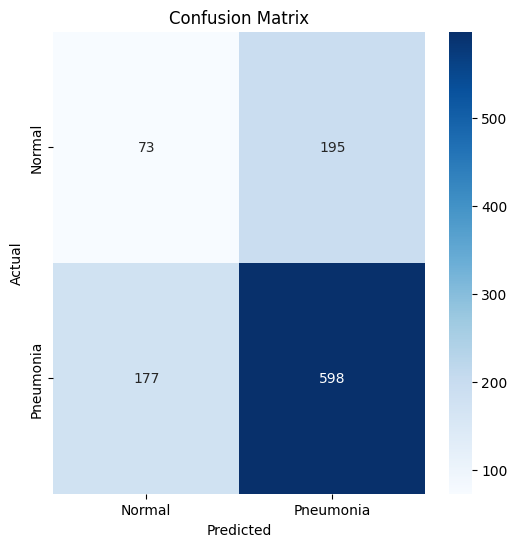

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the paths to the dataset directories
train_dir = '/content/chest_xray/train'

# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Using MobileNetV2 input size
BATCH_SIZE = 32

# Set up data generator with additional augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2  # 20% of training data as validation
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Calculate class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load MobileNetV2 without the top layer for transfer learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[:-10]:  # Adjust -10 based on available memory
    layer.trainable = False
base_model.trainable = True

# Add custom classification layers
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer
outputs = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

model = Model(inputs, outputs)

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name="auc")])

# Set up callbacks: Early Stopping and ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,  # Change to a higher number if needed
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,  # Apply class weights
    callbacks=[early_stopping, lr_schedule]
)

# Evaluate the model on validation data
val_loss, val_accuracy, val_auc = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.2f}, AUC: {val_auc:.2f}")

# Generate confusion matrix
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.round(y_pred).flatten()  # Threshold at 0.5 for binary classification

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import os
print(os.listdir('/content/drive'))

['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']
